# Payment Fraud Detection Predictive Models

Due to confidentiality issues, there are not provided the original features and more background information about the data.

Features V1, V2, ... V28 are the principal components obtained with PCA;
The only features which have not been transformed with PCA are Time and Amount. 
Feature Class is the response variable and it takes value 1 in case of fraud and 0 otherwise.

The datasets contains transactions made by credit cards in September 2013 by cardholders.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import gc
import os
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
pd.set_option('display.max_columns', 100)

In [2]:
RFC_METRIC = 'gini'  
NUM_ESTIMATORS = 100 
NO_JOBS = 4 
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation
RANDOM_STATE = 2018
MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result
IS_LOCAL = False

# Data Extraction

In [125]:
data_df = pd.read_csv("input/creditcard.csv")

In [126]:
print("Credit Card Fraud Detection data -  rows:",data_df.shape[0]," columns:", data_df.shape[1])

Credit Card Fraud Detection data -  rows: 284807  columns: 31


In [127]:
data_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [128]:
data_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


# Data Preprocessing

In [7]:
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Class,V14,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,Amount,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Time
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Data exploration

In [8]:
temp = data_df["Class"].value_counts()
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name="Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Red"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)',
          xaxis = dict(title = 'Class', showticklabels=True), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

/home/user/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/home/user/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



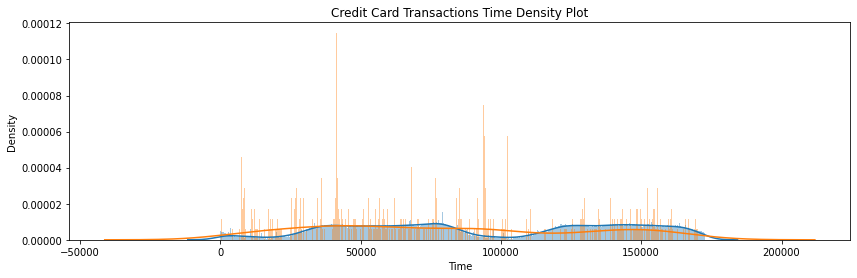

In [10]:
class_0 = data_df.loc[data_df['Class'] == 0]["Time"]
class_1 = data_df.loc[data_df['Class'] == 1]["Time"]
plt.figure(figsize = (14,4))
plt.title('Credit Card Transactions Time Density Plot')
sns.set_color_codes("pastel")
sns.distplot(class_0,kde=True,bins=480)
sns.distplot(class_1,kde=True,bins=480)
plt.show()
hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')

Transactions amount¶

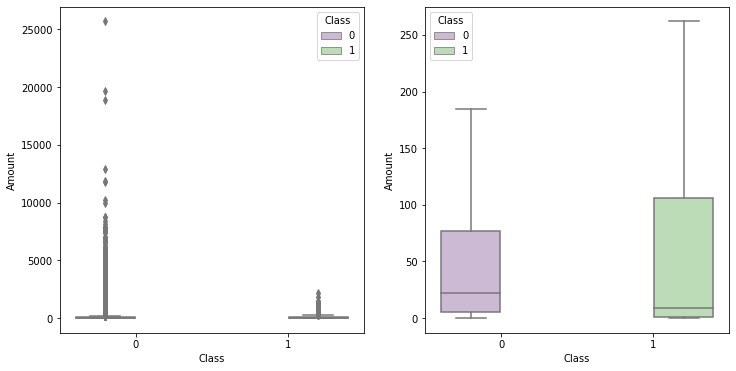

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=False)
plt.show()

In [9]:
tmp = data_df[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']
class_0.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [10]:
class_1.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [14]:
fraud = data_df.loc[data_df['Class'] == 1]

trace = go.Scatter(
    x = fraud['Time'],y = fraud['Amount'],
    name="Amount",
     marker=dict(
                color='rgb(238,23,11)',
                line=dict(
                    color='red',
                    width=1),
                opacity=0.5,
            ),
    text= fraud['Amount'],
    mode = "markers"
)
data = [trace]
layout = dict(title = 'Amount of fraudulent transactions',
          xaxis = dict(title = 'Time [s]', showticklabels=True), 
          yaxis = dict(title = 'Amount'),
          hovermode='closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='fraud-amount')

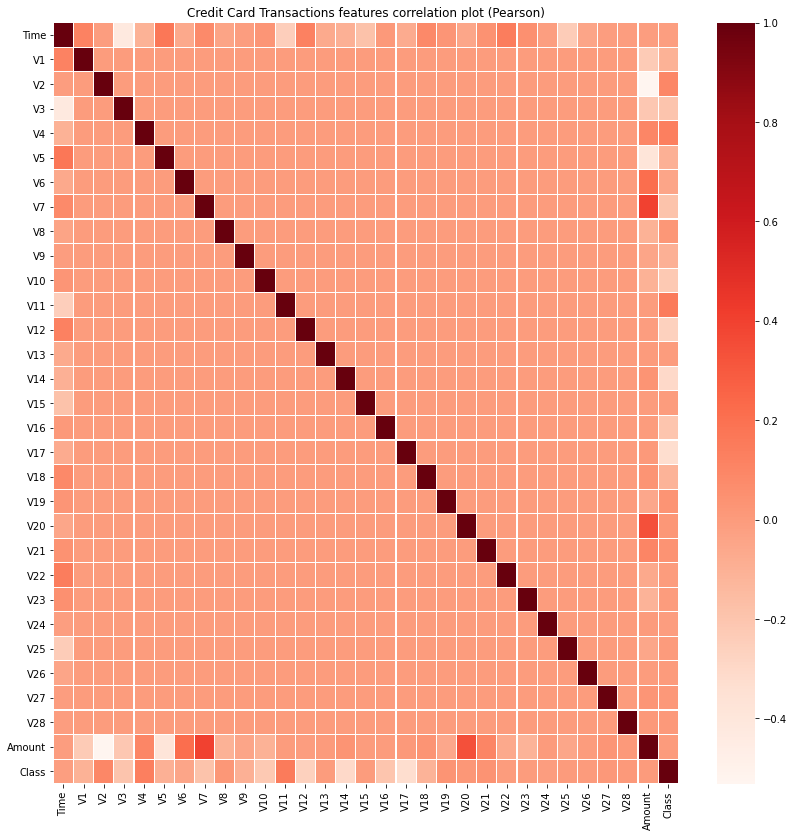

In [15]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = data_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

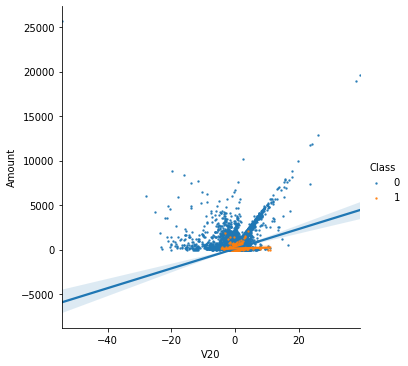

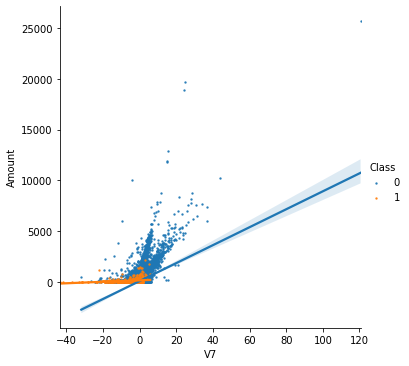

In [16]:
s = sns.lmplot(x='V20', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

/home/user/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:1659: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.

/home/user/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:1659: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.

/home/user/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:1659: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.

/home/user/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:1659: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, bu

/home/user/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:1659: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.

/home/user/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:1659: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.

/home/user/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:1659: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.

/home/user/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:1659: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, bu

<Figure size 432x288 with 0 Axes>

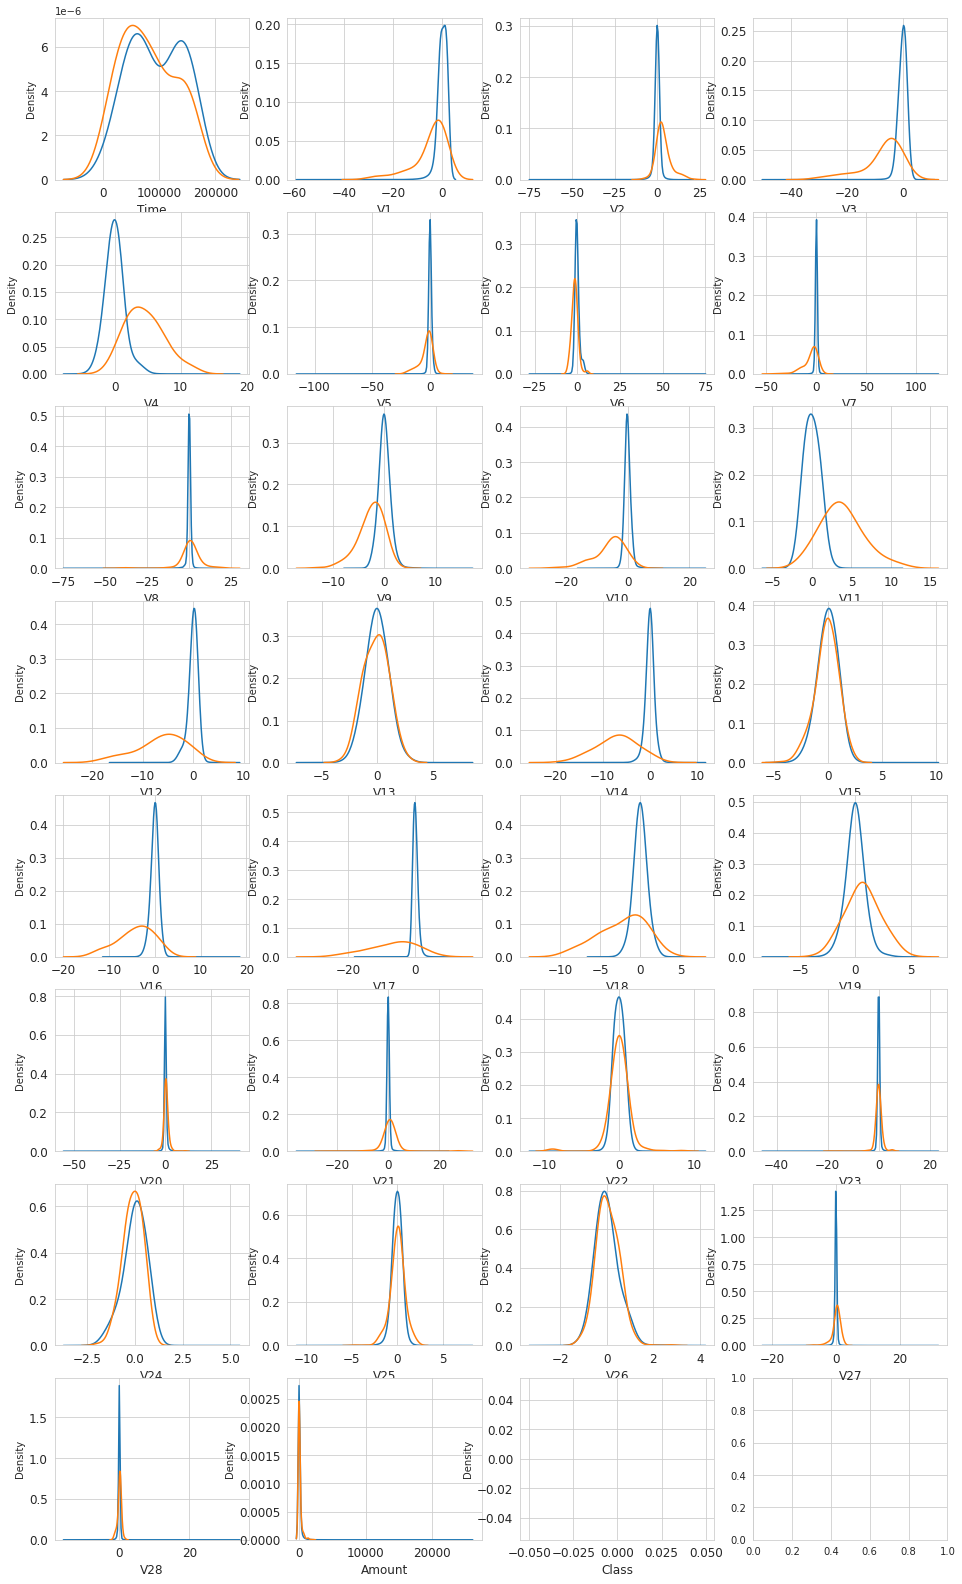

In [21]:
var = data_df.columns.values

i = 0
t0 = data_df.loc[data_df['Class'] == 0]
t1 = data_df.loc[data_df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

# Predictive models

In [9]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

In [10]:
train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

# RandomForestClassifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

In [12]:
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

In [13]:
preds = clf.predict(valid_df[predictors])

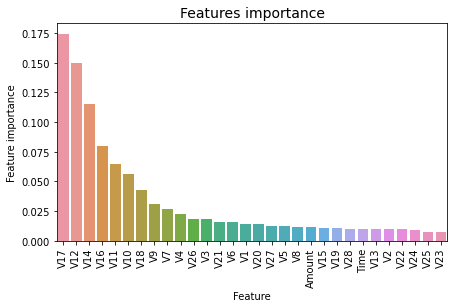

In [14]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   


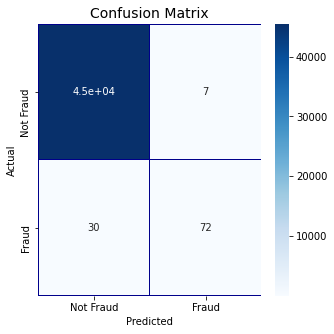

In [15]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [113]:
RF_ACC = roc_auc_score(valid_df[target].values, preds) * 100

In [114]:
RF_ACC 

85.2864197562809

In [92]:
print(classification_report(valid_df[target].values, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45467
           1       0.91      0.71      0.80       102

    accuracy                           1.00     45569
   macro avg       0.96      0.85      0.90     45569
weighted avg       1.00      1.00      1.00     45569



In [102]:
confusion = confusion_matrix(valid_df[target].values, preds)

In [115]:
TP = confusion[0, 0]
TN = confusion[1, 1]
FP = confusion[0, 1]
FN = confusion[1, 0]
classification_error = (FP + FN) / float(TP + TN + FP + FN)


from sklearn import metrics
RF_sensitivity =  (TP / float(FN + TP)) * 100

print(RF_sensitivity)
RF_specificity = (TN / (TN + FP)) * 100
print(RF_specificity)

100.0
100.0


In [17]:
import joblib
joblib.dump(clf, "Random_forest.pkl")

['Random_forest.pkl']

# KNeighborsClassifier

In [18]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)

In [19]:
neigh.fit(train_df[predictors], train_df[target].values)

KNeighborsClassifier(n_neighbors=3)

In [20]:
preds_KNN = neigh.predict(valid_df[predictors])

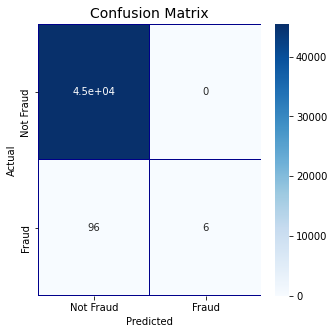

In [21]:
cm = pd.crosstab(valid_df[target].values, preds_KNN, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [116]:
KNN_acc = roc_auc_score(valid_df[target].values, preds_KNN) *100

In [91]:
print(classification_report(valid_df[target].values, preds_KNN))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45467
           1       1.00      0.06      0.11       102

    accuracy                           1.00     45569
   macro avg       1.00      0.53      0.56     45569
weighted avg       1.00      1.00      1.00     45569



In [117]:
confusion = confusion_matrix(valid_df[target].values, preds_KNN)
TP = confusion[0, 0]
TN = confusion[1, 1]
FP = confusion[0, 1]
FN = confusion[1, 0]
classification_error = (FP + FN) / float(TP + TN + FP + FN)


from sklearn import metrics
KNN_sensitivity =  (TP / float(FN + TP)) * 100

print(KNN_sensitivity)
KNN_specificity = (TN / (TN + FP)) * 100
print(KNN_specificity)

99.78930272370124
100.0


In [ ]:
import joblib
joblib.dump(clf, "KNN.pkl")

# KNN + RF

In [23]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [24]:
from sklearn.ensemble import StackingClassifier
def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('rf', RandomForestClassifier()))
	level1 = KNeighborsClassifier()
	# define the stacking ensemble
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model

In [25]:
# get a list of models to evaluate
def get_models():
	models = dict()
	models['stacking'] = get_stacking()
	return models

In [26]:
X = train_df[predictors].values
y = train_df[target].values

In [28]:
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

In [ ]:
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

# BMR + RF

In [29]:
from costcla.models import BayesMinimumRiskClassifier
from costcla.metrics import savings_score

/home/user/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.



In [67]:
y_prob_test = clf.predict_proba(test_df[predictors])
y_pred_test_rf = clf.predict(test_df[predictors])
f_bmr = BayesMinimumRiskClassifier()
f_bmr.fit(y_pred_test_rf, y_prob_test)
y_pred_test_bmr = clf.predict(valid_df[predictors])

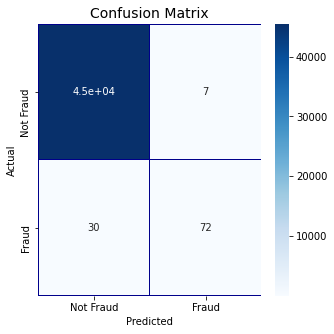

In [68]:
cm = pd.crosstab(valid_df[target].values, y_pred_test_bmr, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [90]:
print(classification_report(valid_df[target].values, y_pred_test_bmr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45467
           1       0.91      0.71      0.80       102

    accuracy                           1.00     45569
   macro avg       0.96      0.85      0.90     45569
weighted avg       1.00      1.00      1.00     45569



In [118]:
RFBMR_acc = roc_auc_score(valid_df[target].values, y_pred_test_bmr) * 100

In [119]:
confusion = confusion_matrix(valid_df[target].values, y_pred_test_bmr)
TP = confusion[0, 0]
TN = confusion[1, 1]
FP = confusion[0, 1]
FN = confusion[1, 0]
classification_error = (FP + FN) / float(TP + TN + FP + FN)


from sklearn import metrics
BMRRF_sensitivity =  (TP / float(FN + TP)) * 100

print(BMRRF_sensitivity)
BMRRF_specificity = (TN / (TN + FP)) * 100
print(BMRRF_specificity)

99.9340514398769
91.13924050632912


In [ ]:
import joblib
joblib.dump(clf, "BMR.pkl")

# Meta - Learning

In [76]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential, load_model
from keras.layers import Dense, LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline

In [80]:
input_size = train_df[predictors].shape[1]
epochs = 10
batch_size = 20
classifier = Sequential()
classifier.add(Dense(10000, activation='tanh', input_shape=(input_size,)))
classifier.add(Dense(1, activation='tanh'))
sgd = keras.optimizers.SGD(lr=alpha_inner)
classifier.compile(optimizer=sgd, loss="mse", metrics=["accuracy"])
classifier.summary()

classifier.fit(train_df[predictors], train_df[target].values, validation_split=0.2, epochs=epochs, batch_size=batch_size, shuffle=True)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 10000)             310000    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 10001     
Total params: 320,001
Trainable params: 320,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7291/7291 [==============================] - 61s 8ms/step - loss: 0.9983 - accuracy: 0.0018 - val_loss: 0.9986 - val_accuracy: 0.0014
Epoch 2/10
7291/7291 [==============================] - 64s 9ms/step - loss: 0.9984 - accuracy: 0.0016 - val_loss: 0.9986 - val_accuracy: 0.0014
Epoch 3/10
7291/7291 [==============================] - 69s 9ms/step - loss: 0.9984 - accuracy: 0.0016 - val_loss: 0.9986 - val_accuracy: 0.0014
Epoch 4/10
7291/7291 [==============================] - 80s 11ms/step - los

In [81]:
y_pred = classifier.predict(train_df[predictors])
y_pred = y_pred>=0.5

In [99]:
metalearning = classifier.evaluate(train_df[predictors], train_df[target].values)

5697/5697 [==============================] - 46s 8ms/step - loss: 0.9984 - accuracy: 0.0016


In [121]:
metalearning_acc = (metalearning[0]) * 100

In [88]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support, classification_report, make_scorer

In [89]:
print ("precision: {:.2f}".format(precision_score(y_pred, y_pred)))
print ("recall: {:.2f}".format(recall_score(y_pred, y_pred)))
print ("f1 score: {:.2f}".format(f1_score(y_pred, y_pred)))
print ("\n")

precision: 1.00
recall: 1.00
f1 score: 1.00




In [96]:
cm = confusion_matrix(y_pred, y_pred)
print ("Confusion matrix:\n", cm)
print ("\n")


Confusion matrix:
 [[     1      0]
 [     0 182275]]




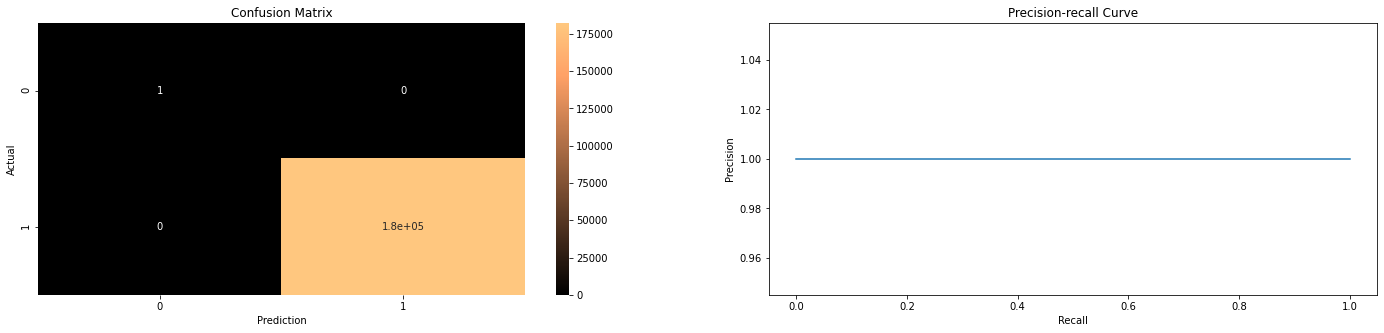

In [97]:
fig, ax = plt.subplots(1, 2, figsize=(24,5))
# annot: If True, write the data value in each cell
sns.heatmap(cm, ax=ax[0], annot=True, cmap=plt.cm.copper)
ax[0].set_title("Confusion Matrix")
ax[0].set_xlabel("Prediction")
ax[0].set_ylabel("Actual")

precision, recall, _ = precision_recall_curve(y_pred, y_pred)
ax[1].plot(recall, precision)
ax[1].set_title("Precision-recall Curve")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
plt.show()

In [120]:
confusion = confusion_matrix(y_pred, y_pred)
TP = confusion[0, 0]
TN = confusion[1, 1]
FP = confusion[0, 1]
FN = confusion[1, 0]
classification_error = (FP + FN) / float(TP + TN + FP + FN)


from sklearn import metrics
MetaL_sensitivity =  (TP / float(FN + TP)) * 100

print(MetaL_sensitivity)
MetaL_specificity = (TN / (TN + FP)) * 100
print(MetaL_specificity)

100.0
100.0


In [ ]:
import joblib
joblib.dump(clf, "Metalearning.pkl")

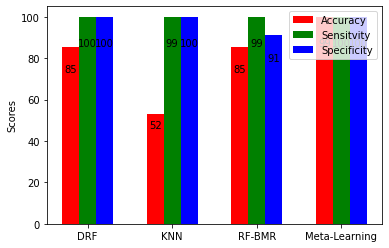

In [123]:
import numpy as np
import matplotlib.pyplot as plt

N = 4
ind = np.arange(N)  # the x locations for the groups
width = 0.2      # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

yvals = [RF_ACC,KNN_acc,RFBMR_acc,metalearning_acc]

rects1 = ax.bar(ind, yvals, width, color='r')
zvals = [RF_sensitivity,KNN_sensitivity,BMRRF_sensitivity,MetaL_sensitivity]
rects2 = ax.bar(ind+width, zvals, width, color='g')
kvals = [RF_specificity,KNN_specificity,BMRRF_specificity,MetaL_specificity]
rects3 = ax.bar(ind+width*2, kvals, width, color='b')

ax.set_ylabel('Scores')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('DRF','KNN','RF-BMR','Meta-Learning') )
ax.legend( (rects1[0], rects2[0], rects3[0]), ('Accuracy', 'Sensitvity', 'Specificity') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 0.85*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.show()

# Accuracy

/home/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning:

'from_array' is deprecated and will be removed in a future version. Please use the pd.Series(..) constructor instead.



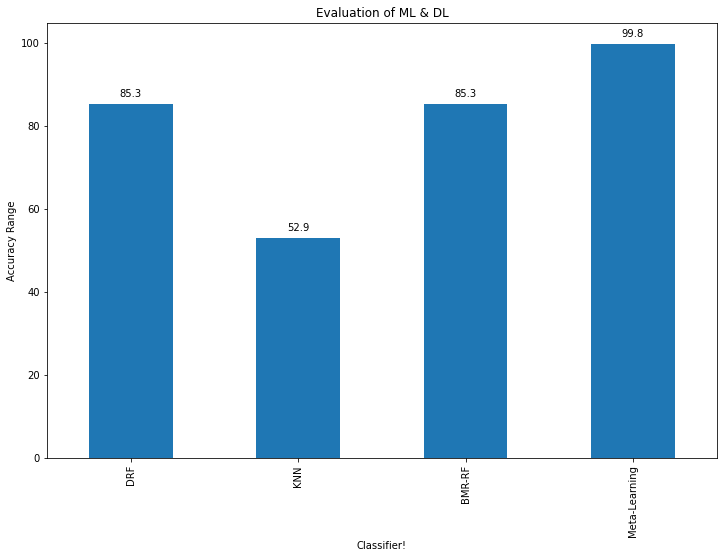

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Bring some raw data.
frequencies = [RF_ACC,KNN_acc,RFBMR_acc,metalearning_acc]

# In my original code I create a series and run on that,
# so for consistency I create a series from the list.
freq_series = pd.Series.from_array(frequencies)

x_labels = ['DRF','KNN','BMR-RF','Meta-Learning']

# Plot the figure.
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
ax.set_title('Evaluation of ML & DL')
ax.set_xlabel('Classifier!')
ax.set_ylabel('Accuracy Range')
ax.set_xticklabels(x_labels)


def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.
add_value_labels(ax)
plt.show()
#plt.savefig("image.png")